In this notebook we determine a set of parameters allowing EC-activity-mediated replay to occur.

# Get potentiated EC -> PC weights from trajectory through room

### Set params

In [2]:
%reset -f
%matplotlib inline
from IPython import display
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import os

from anim import build_frames, merge_frames, create_mp4
from aux import save_time_file
from ntwk import LIFNtwk
import plot
from traj import RandomTraj, InferredTraj, upstream_spks_from_traj

import PARAMETERS as P

cc = np.concatenate


# GENERAL PARAMS
RUN_DIR = 'sims/replay/run'
REPLAY_DIR = 'sims/replay/replay'

TIME_FILE_RUN = os.path.join(RUN_DIR, 'time.npy')
TRAJ_FILE_RUN = os.path.join(RUN_DIR, 'traj.npy')
NTWK_FILE_RUN = os.path.join(RUN_DIR, 'ntwk.npy')
INFERRED_FILE_RUN = os.path.join(RUN_DIR, 'inferred.npy')

BOX = (P.BOX_L, P.BOX_R, P.BOX_B, P.BOX_T)
DUR = 15

ASPECT = (P.BOX_T - P.BOX_B) / (P.BOX_R - P.BOX_L)
FIG_SIZE = np.array([10, 10*ASPECT])

# TRAJ PARAMS
SEED = 2

XY_0 = (P.BOX_L, P.BOX_T)
V_0 = (.141, -.141)
T_CORR = 100

# NTWK PARAMS
N_PC = 1800
N_INH = N_PC//9
N = N_PC + N_INH
N_UP = 2*N_PC

SYNS = ['AMPA', 'NMDA']

# upstream AMPA place-tuned cxns
W_UP_AMPA = np.concatenate(
    [P.W_A_PC_PL * np.eye(N_PC), np.zeros((N_PC, N_PC))], axis=1)
# upstream NMDA cxns from ECII 
W_UP_NMDA = np.concatenate(
    [np.zeros((N_PC, N_PC)), P.W_N_PC_EC_I * np.eye(N_PC)], axis=1)

WS_UP = {'AMPA': W_UP_AMPA, 'NMDA': W_UP_NMDA}

NTWK_KWARGS = {
    't_m': P.T_M_PC,  # (s)
    'e_leak': P.E_L_PC,  # (V)
    'v_th': P.V_TH_PC,  # (V)
    'v_reset': P.V_RESET_PC,  # (V)
    't_r': P.T_R,  # (s)
    'es_syn': {'AMPA': P.E_A, 'NMDA': P.E_N},  # (V)
    'ts_syn': {'AMPA': P.T_A, 'NMDA': P.T_N},  # (s)
    'ws_rcr': {'AMPA': np.zeros((N_PC, N_PC)), 'NMDA': np.zeros((N_PC, N_PC))},  # (unitless)
    'ws_up': WS_UP,
}

# PLASTICITY PARAMS
W_AMPA_PLASTIC = np.zeros(W_UP_AMPA.shape, dtype=bool)
W_NMDA_PLASTIC = np.concatenate([np.zeros((N_PC, N_PC)), np.eye(N_PC)], axis=1).astype(bool)

MASKS_PLASTIC = {
    'AMPA': W_AMPA_PLASTIC,
    'NMDA': W_NMDA_PLASTIC,
}

PLASTICITY = {
    'masks': MASKS_PLASTIC,
    'w_ec_ca3_maxs': {'AMPA': np.nan, 'NMDA': P.W_N_PC_EC_F},
    'T_W': P.T_W, 'T_C': P.T_C, 'C_S': P.C_S, 'BETA_C': P.B_C,
}

### Generate trajectory

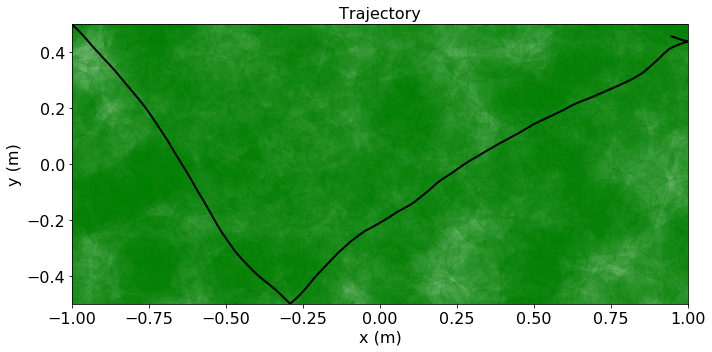

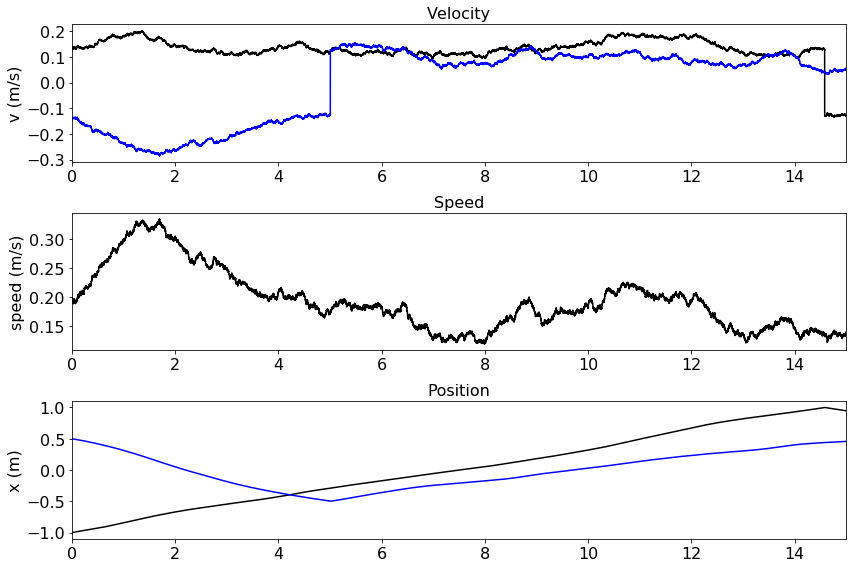

In [2]:
np.random.seed(SEED)

ts = np.arange(0, DUR, P.DT)

traj = RandomTraj(ts, P.S_TRAJ, T_CORR, XY_0, V_0, BOX)

# place field ranges
pf_lb = [P.BOX_L - 0.1 * (P.BOX_R - P.BOX_L), P.BOX_B - 0.1 * (P.BOX_T - P.BOX_B)]
pf_ub = [P.BOX_R + 0.1 * (P.BOX_R - P.BOX_L), P.BOX_T + 0.1 * (P.BOX_T - P.BOX_B)]
centers = np.random.uniform(pf_lb, pf_ub, (N_PC, 2)).T

stds = P.L_PL * np.ones(centers.shape[1])
max_rates = P.R_MAX_PL * np.ones(centers.shape[1])

save_time_file(TIME_FILE_RUN, ts)
traj.save(TRAJ_FILE_RUN)

# plot trajectory and place fields
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE, tight_layout=True)

# trajectory
ax.plot(*traj.xys.T, lw=2, color='k')

# place fields
for center, std in zip(centers.T, stds):
    ell = Ellipse(center, width=std, height=std, angle=0, color='g', alpha=0.1)
    ax.add_artist(ell)
    
ax.set_xlim(BOX[:2])
ax.set_ylim(BOX[2:])
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Trajectory')

plot.set_font_size(ax, 16)

fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True)

# velocity time-series
axs[0].plot(ts, traj.vs[:, 0], c='k')
axs[0].plot(ts, traj.vs[:, 1], c='b')
axs[0].set_xlim(ts[0], ts[-1])
axs[0].set_ylabel('v (m/s)')
axs[0].set_title('Velocity')

# speed time-series
speed = np.sqrt(traj.vs[:, 0]**2 + traj.vs[:, 1]**2)
axs[1].plot(ts, speed, c='k')
axs[1].set_xlim(ts[0], ts[-1])
axs[1].set_ylabel('speed (m/s)')
axs[1].set_title('Speed')

# position time-series
axs[2].plot(ts, traj.xys[:, 0], c='k')
axs[2].plot(ts, traj.xys[:, 1], c='b')
axs[2].set_xlim(ts[0], ts[-1])
axs[2].set_ylabel('x (m)')
axs[2].set_title('Position')

for ax in axs:
    plot.set_font_size(ax, 16)

### Generate place-tuned and zero-valued EC->PC inputs

In [3]:
spks_up_pl = upstream_spks_from_traj(ts, traj.xys, centers, stds, max_rates)
spks_up_ec = np.zeros((len(ts), N_PC), dtype=int)

spks_up = np.concatenate([spks_up_pl, spks_up_ec], axis=1)

### Compute network response

In [4]:
# make ntwk and run simulation
ntwk = LIFNtwk(**NTWK_KWARGS, plasticity=PLASTICITY)
vs_init = P.E_L_PC * np.ones(N_PC)
resp = ntwk.run(spks_up=spks_up, dt=P.DT, vs_init=vs_init)
resp.place_field_centers = centers

resp.save(NTWK_FILE_RUN);

### Raster plot

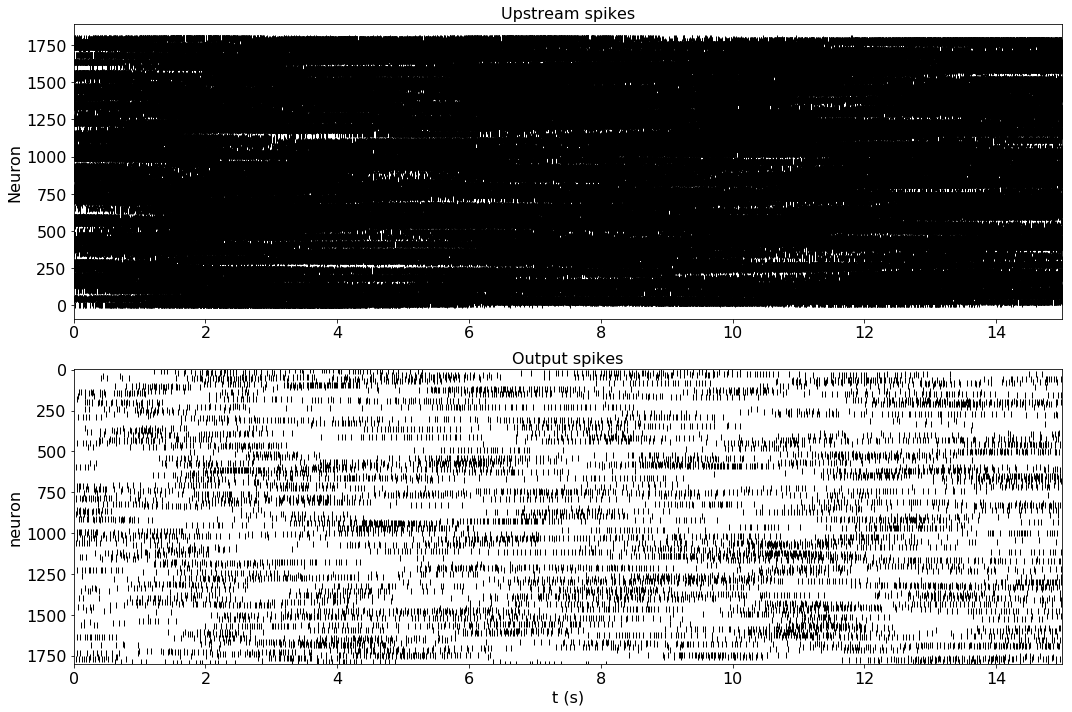

In [5]:
gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(15, 10), tight_layout=True)

axs = [
    fig.add_subplot(gs[0, :]),
    fig.add_subplot(gs[1, :]),
]

# raster plot of place-sensitive cell responses
spk_times_up = spks_up[:, :N_PC].nonzero()[0] * P.DT

axs[0].scatter(spk_times_up, spks_up[:, :N_PC].nonzero()[1], marker='|', lw=1, c='k')
axs[0].set_xlim(ts[0], ts[-1])
axs[0].set_ylabel('Neuron')
axs[0].set_title('Upstream spikes')

plot.raster(
    axs[1],
    TIME_FILE_RUN,
    NTWK_FILE_RUN)

axs[1].set_xlim(ts[0], ts[-1])
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('neuron')
axs[1].set_title('Output spikes') 

for ax in axs:
    plot.set_font_size(ax, 16)

### EC-CA3 weight changes for most active and least active cells

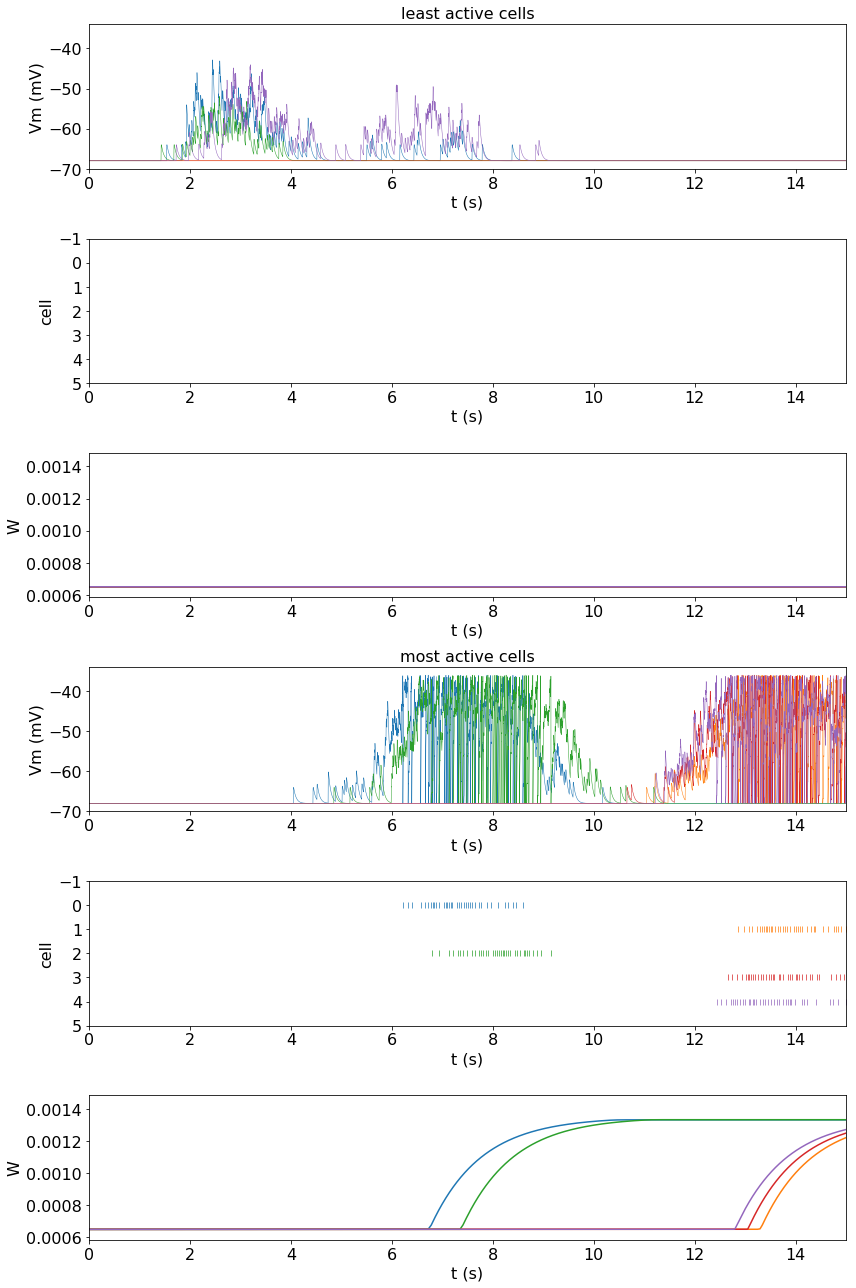

In [6]:
# find least and most active cells during running period
n_plot = 5

spk_cts_run = resp.spks.sum(axis=0)
order = np.argsort(spk_cts_run)

least = order[:n_plot]
most = order[-n_plot:]

# get voltages, spikes, and EC-CA3 weights
vs_least = resp.vs[:, least]
vs_most = resp.vs[:, most]

spks_least = resp.spks[:, least]
spks_most = resp.spks[:, most]

ws_plastic_least = resp.ws_plastic['NMDA'][:, least]
ws_plastic_most = resp.ws_plastic['NMDA'][:, most]


# plot vs, spks, and ws_plastic for least and most active cell sets
fig, axs = plt.subplots(6, 1, figsize=(12, 18), tight_layout=True)

for ax_offset, title, vs, spks, ws_plastic in zip(
        [0, 3], ['least active cells', 'most active cells'],
        [vs_least, vs_most], [spks_least, spks_most],
        [ws_plastic_least, ws_plastic_most]):
    
    ax_vs = axs[ax_offset]
    ax_spks = axs[ax_offset+1]
    ax_ws = axs[ax_offset+2]
    
    # plot vs
    ax_vs.plot(ts, 1000*vs, lw=0.5)
    
    ax_vs.set_xlim(ts[0], ts[-1])
    ax_vs.set_ylim(-70, -34)
    ax_vs.set_xlabel('t (s)')
    ax_vs.set_ylabel('Vm (mV)')
    ax_vs.set_title(title)
    
    # plot spks
    for cell_ctr, spks_ in enumerate(spks.T):
        spk_ts = spks_.nonzero()[0] * P.DT
        ax_spks.scatter(spk_ts, cell_ctr*np.ones(spk_ts.shape), marker='|', lw=0.7)
        
    ax_spks.set_xlim(ts[0], ts[-1])
    ax_spks.set_ylim(n_plot, -1)
    ax_spks.set_xlabel('t (s)')
    ax_spks.set_ylabel('cell')
    
    # plot ws_plastic
    ax_ws.plot(ts, ws_plastic)
    
    ax_ws.set_xlim(ts[0], ts[-1])
    ax_ws.set_ylim(0.9*P.W_N_PC_EC_I, 1.1*P.W_N_PC_EC_F)
    ax_ws.set_xlabel('t (s)')
    ax_ws.set_ylabel('W')
    
for ax in axs:
    plot.set_font_size(ax, 16)

### Trajectory inferred from network activity

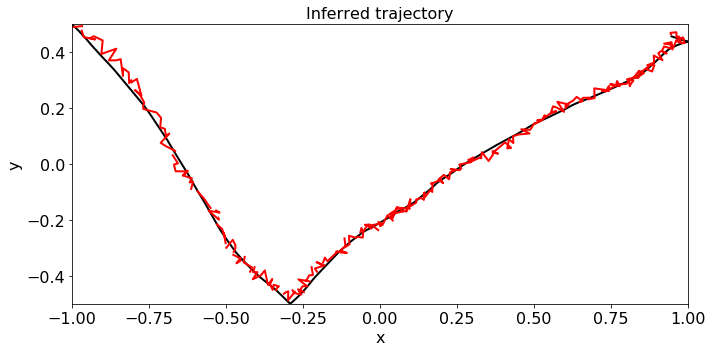

In [7]:
inferred = InferredTraj(
    ntwk_file=NTWK_FILE_RUN,
    time_file=TIME_FILE_RUN,
    window=0.05)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE, tight_layout=True)
ax.plot(*traj.xys.T, color='k', lw=2)
ax.plot(*inferred.xys.T, color='r', lw=2)

ax.set_xlim(BOX[:2])
ax.set_ylim(BOX[2:])

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_title('Inferred trajectory')

plot.set_font_size(ax, 16)

inferred.save(INFERRED_FILE_RUN);

### Component frames for animation

In [9]:
frames_traj = build_frames.traj(
    save_prefix=os.path.join(RUN_DIR, 'traj/frame'),
    time_file=TIME_FILE_RUN,
    traj_file=TRAJ_FILE_RUN,
    box=BOX,
    fps=60,
    title='Trajectory',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=.8*FIG_SIZE,
    verbose=True)

In [10]:
frames_ntwk = build_frames.ntwk_activity(
    save_prefix=os.path.join(RUN_DIR, 'ntwk/frame'),
    time_file=TIME_FILE_RUN,
    ntwk_file=NTWK_FILE_RUN,
    box=BOX,
    fps=60,
    resting_size=30,
    spk_size=350,
    amp=4,
    positions=centers,
    frames_per_spk=2,
    title='Network activity',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=.8*FIG_SIZE)

In [11]:
frames_inferred = build_frames.traj(
    save_prefix=os.path.join(RUN_DIR, 'inferred/frame'),
    time_file=TIME_FILE_RUN,
    traj_file=INFERRED_FILE_RUN,
    box=BOX,
    fps=60,
    location_size=200,
    location_color=(0, 0, 1),
    cov_cutoff=np.inf,
    title='Inferred trajectory',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=.8*FIG_SIZE,
    verbose=True)

### Final (merged) frames

In [12]:
save_prefix = os.path.join(RUN_DIR, 'merged/frame')
rects = [(0, 0, 1, 1), (1, 0, 2, 1), (0, 1, 1, 2)]
size = (2, 2)

frames_merged = merge_frames(
    [frames_traj, frames_ntwk, frames_inferred], save_prefix, rects, size)

### Final animation

In [10]:
movie = create_mp4(
    frames_merged, os.path.join(RUN_DIR, 'movie'), playback_fps=30, verbose=True)

Loading source images...
Source images loaded.
Generating movie and saving at "sims/replay/run/movie.mp4"...
Movie generated.


# Build network starting with potentiated EC -> PC weights

### Load final weights from saved run-epoch ntwk response

In [3]:
from aux import load

data = load(NTWK_FILE_RUN)
w_up_n_ = data['ws_up']['NMDA']
w_plastic_n_ = data['ws_plastic']['NMDA']
mask_n_ = data['masks_plastic']['NMDA']

w_up_n_[mask_n_] = w_plastic_n_[-1]

place_field_centers_ = data['place_field_centers']

data = None

In [175]:
from ntwk import cxns_pcs_rcr

# GENERAL PARAMS
TIME_FILE_REPLAY = os.path.join(REPLAY_DIR, 'time.npy')
TRAJ_FILE_REPLAY = os.path.join(REPLAY_DIR, 'traj.npy')
NTWK_FILE_REPLAY = os.path.join(REPLAY_DIR, 'ntwk.npy')
INFERRED_FILE_REPLAY = os.path.join(REPLAY_DIR, 'inferred.npy')

# NTWK PARAMS
CELL_TYPES = np.array(N_PC*['PC'] + N_INH*['INH'])
SYNS = ['AMPA', 'NMDA', 'GABA']

E_AHP = -0.07
T_AHP = 0.01
W_AHP = 0.03

Z_PC = 2
L_PC = 0.061
EC_RATE = 50

DUR = 0.8

REPLAY_START_POS = (0.8, 0.3)
REPLAY_START_TIME = 0.4

# VISUALIZATION PARAMS
POS_INH_MEAN = (0, -1)
POS_INH_SPREAD = (0.3, 0.1)

BOX_PC = (P.BOX_L, P.BOX_R, P.BOX_B, P.BOX_T)
BOX_FULL = (P.BOX_L, P.BOX_R, -1.5, P.BOX_T)

ASPECT_PC = (P.BOX_T - P.BOX_B) / (P.BOX_R - P.BOX_L)
ASPECT_FULL = (P.BOX_T + 1.5) / (P.BOX_R - P.BOX_L)

FIG_SIZE_PC = np.array([10, 10*ASPECT_PC])
FIG_SIZE_FULL = np.array([10, 10*ASPECT_FULL])

### Build and save timestamp array

In [176]:
ts = np.arange(0, DUR, P.DT)
save_time_file(TIME_FILE_REPLAY, ts);

### Examine weight matrix at start of replay epoch

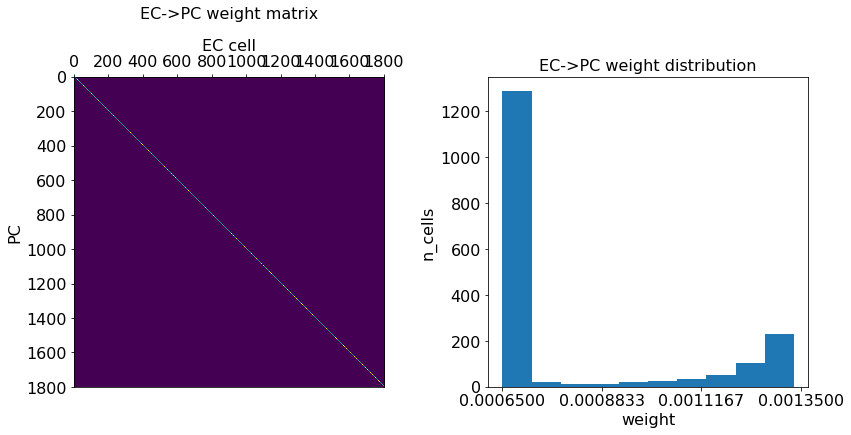

In [177]:
# show NMDA weight matrix and distribution of diagonal weights
fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
axs[0].imshow(w_up_n_[:, N_PC:], interpolation='nearest')
axs[0].xaxis.tick_top()
axs[0].xaxis.set_label_position('top')
axs[0].set_xlabel('EC cell')
axs[0].set_ylabel('PC')
axs[0].set_title('EC->PC weight matrix\n\n\n')

axs[1].hist(np.diagonal(w_up_n_[:, N_PC:]))
axs[1].set_xticks(np.linspace(P.W_N_PC_EC_I, P.W_N_PC_EC_F, 4))
axs[1].set_xlabel('weight')
axs[1].set_ylabel('n_cells')
axs[1].set_title('EC->PC weight distribution')

for ax in axs:
    plot.set_font_size(ax, 16)

### Build network with recurrence

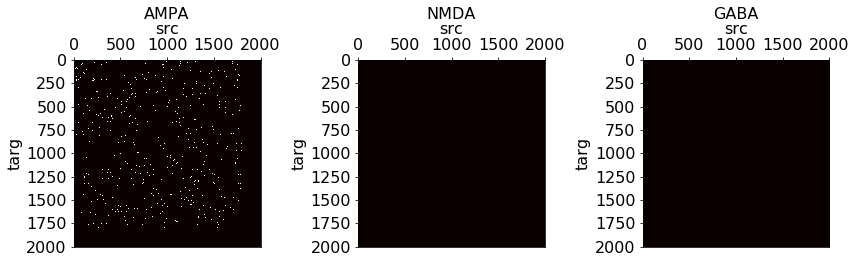

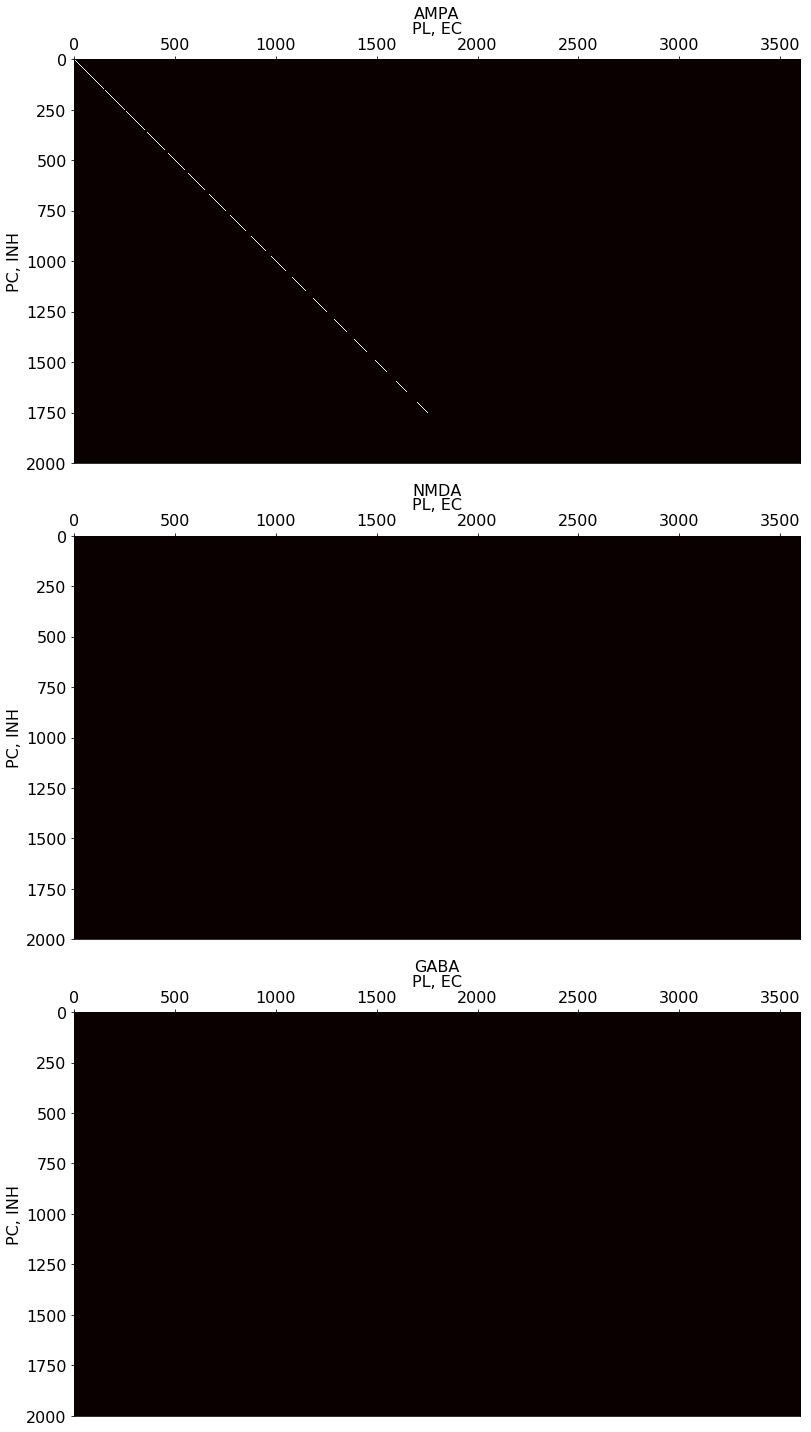

In [178]:
# build PC-PC recurrent matrix
np.random.seed(0)

# set up place fields
place_field_centers = np.nan * np.zeros((2, N))
place_field_centers[:, :N_PC] = place_field_centers_

# set up cxns

# recurrent
w_a_rcr = np.zeros((N, N))
w_a_rcr[cxns_pcs_rcr(place_field_centers, z_pc=Z_PC, l_pc=L_PC)] = P.W_A_PC_PC

ws_rcr = {'AMPA': w_a_rcr, 'NMDA': np.zeros((N, N)), 'GABA': np.zeros((N, N))}

# upstream
w_up_a = np.zeros((N, N_UP))
w_up_a[:N_PC, :N_PC] = P.W_A_PC_PL*np.eye(N_PC)

w_up_n = np.zeros((N, N_UP))
w_up_n[:N_PC] = w_up_n_

w_up_g = np.zeros((N, N_UP))

ws_up = {'AMPA': w_up_a, 'NMDA': w_up_n, 'GABA': w_up_g}

# show full recurrent ntwk
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

for ax, syn in zip(axs, SYNS):
    ax.imshow(ws_rcr[syn], cmap='hot')
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    ax.set_xlabel('src')
    ax.set_ylabel('targ')
    ax.set_title('{}\n\n'.format(syn))
    
for ax in axs:
    plot.set_font_size(ax, 16)
    
# show upstream ntwks
fig, axs = plt.subplots(3, 1, figsize=(12, 20), tight_layout=True)

for ax, syn in zip(axs, SYNS):
    ax.imshow(ws_up[syn], cmap='hot', vmin=0, vmax=ws_up[syn].max())
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    ax.set_xlabel('PL, EC')
    ax.set_ylabel('PC, INH')
    ax.set_title('{}\n\n'.format(syn))
    
for ax in axs:
    plot.set_font_size(ax, 16)

In [179]:
# build ntwk
t_m = cc([P.T_M_PC*np.ones(N_PC), P.T_M_INH*np.ones(N_INH)])
e_l = cc([P.E_L_PC*np.ones(N_PC), P.E_L_INH*np.ones(N_INH)])
v_th = cc([P.V_TH_PC*np.ones(N_PC), P.V_TH_INH*np.ones(N_INH)])
v_reset = cc([P.V_RESET_PC*np.ones(N_PC), P.V_RESET_PC*np.ones(N_INH)])

es_syn = {'AMPA': P.E_A, 'NMDA': P.E_N, 'GABA': P.E_G}
ts_syn = {'AMPA': P.T_A, 'NMDA': P.T_N, 'GABA': P.T_G}

ntwk = LIFNtwk(
    t_m=t_m, e_leak=e_l, v_th=v_th, v_reset=v_reset, t_r=P.T_R,
    e_ahp=E_AHP, t_ahp=T_AHP, w_ahp=W_AHP,
    es_syn=es_syn, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

# Provide synchronous place-tuned PC input under EC activation

In [180]:
# build upstream spk inputs
spks_up = np.zeros((len(ts), N_UP))

# add EC inputs
spks_up[:, N_PC:] = np.random.poisson(EC_RATE*P.DT, (len(ts), N_PC))

# add synchronous place-tuned PC input
# get cell idxs for cells within an L_PL radius of REPLAY_START_POS
dx = place_field_centers[0] - REPLAY_START_POS[0]
dy = place_field_centers[1] - REPLAY_START_POS[1]
dx[np.isnan(dx)] = np.inf
dy[np.isnan(dy)] = np.inf
mask_near = np.sqrt(dx**2 + dy**2) < P.L_PL

spks_up[int(REPLAY_START_TIME/P.DT), :N_PC][mask_near[:N_PC]] = 3

### Run ntwk

In [181]:
# run ntwk
vs_init = e_l.copy()

resp = ntwk.run(spks_up=spks_up, dt=P.DT, vs_init=vs_init)
resp.place_field_centers = place_field_centers
resp.cell_types = CELL_TYPES

# save responses
resp.save(NTWK_FILE_REPLAY);

### Show raster plot response

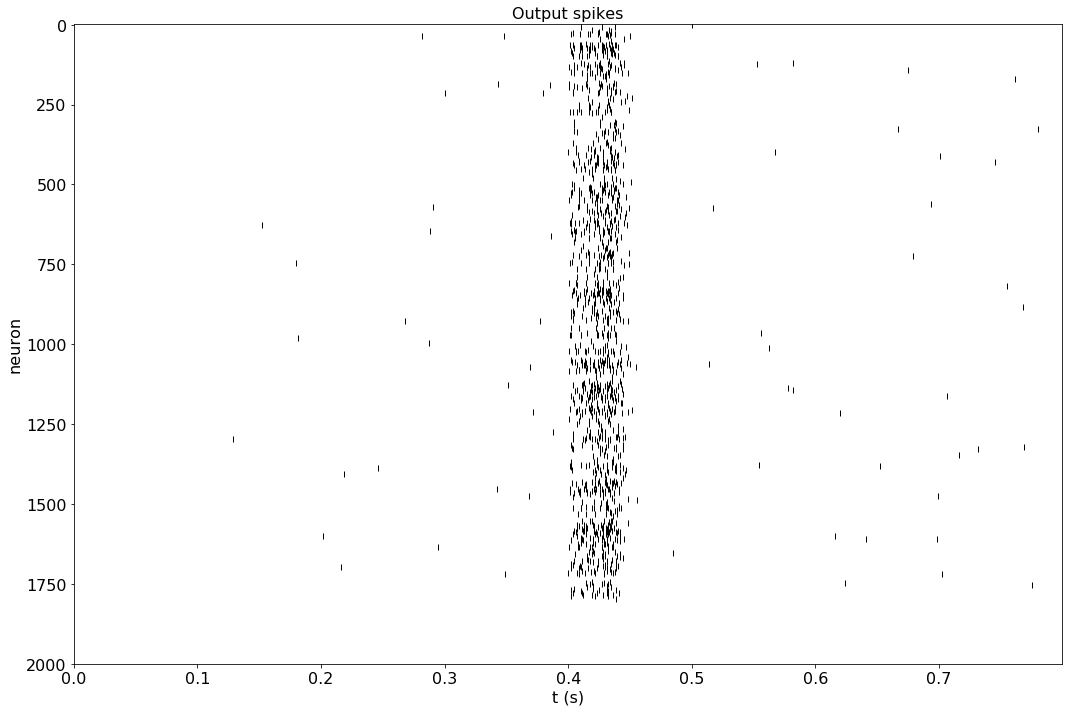

In [182]:
# make raster plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10), tight_layout=True)

plot.raster(ax, TIME_FILE_REPLAY, NTWK_FILE_REPLAY, colors=(N_PC*['k'] + N_INH*['b']))

ax.set_xlim(ts[0], ts[-1])
ax.set_xlabel('t (s)')
ax.set_ylabel('neuron')
ax.set_title('Output spikes')

plot.set_font_size(ax, 16)

# Create slow motion video of network response

In [183]:
# assign visual positions
positions = place_field_centers.copy()
positions[0, -N_INH:] = np.random.normal(POS_INH_MEAN[0], POS_INH_SPREAD[0], N_INH)
positions[1, -N_INH:] = np.random.normal(POS_INH_MEAN[1], POS_INH_SPREAD[1], N_INH)

In [184]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

frames_ntwk = build_frames.ntwk_activity(
    save_prefix=os.path.join(REPLAY_DIR, 'ntwk/frame'),
    time_file=TIME_FILE_REPLAY,
    ntwk_file=NTWK_FILE_REPLAY,
    box=BOX_FULL,
    fps=240,
    resting_size=30,
    spk_size=400,
    amp=3,
    positions=positions,
    default_color={'PC': 'k', 'INH': 'b'},
    cxn_color={('PC', 'PC'): 'k', ('PC', 'INH'): (0, 0, 0.5), ('INH', 'PC'): (0, 0.5, 0), ('INH', 'INH'): 'k'},
    cxn_lw={('PC', 'PC'): 0.15, ('PC', 'INH'): 0.05, ('INH', 'PC'): 0.05, ('INH', 'INH'): 0},
    cxn_zorder={('PC', 'PC'): -1, ('PC', 'INH'): -2, ('INH', 'PC'): -2, ('INH', 'INH'): 0},
    frames_per_spk=2,
    y_ticks=[-1, -0.5, 0.5],
    y_tick_labels=['INH', -0.5, 0.5],
    title='Network activity',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=FIG_SIZE_FULL,
    verbose=True)

Using timestamp file "sims/replay/replay/time.npy" and activity file "sims/replay/replay/ntwk.npy".
Frames will be saved with prefix "sims/replay/replay/ntwk/frame".
Loading timestamps and network activity data...
Downsampling data from 2000.0 Hz to 240 fps...
Data downsampled.
Data loaded.


/Users/melete/anaconda/envs/py3/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Generating and saving 192 frames...
22 frames completed after 30.663 s...
40 frames completed after 62.372 s...
61 frames completed after 93.853 s...
86 frames completed after 124.477 s...
111 frames completed after 155.196 s...
134 frames completed after 185.196 s...
158 frames completed after 215.688 s...
183 frames completed after 245.959 s...
All frames written to disk.


In [185]:
movie = create_mp4(
    frames_ntwk, os.path.join(REPLAY_DIR, 'ntwk_movie'), playback_fps=30, verbose=True)

Loading source images...
Source images loaded.
Generating movie and saving at "sims/replay/replay/ntwk_movie.mp4"...
Movie generated.
